# Capstone Project

You are working as a Machine Learning Engineer in an e-commerce company named 'Ebuss'. Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings.

Below steps are to be performed .

1. Exploratory data analysis
2. Data cleaning
3. Text preprocessing
4. Feature extraction
5. Model Building \
  5.1. Logistic regression \
  5.2. Random forest \
  5.3. XGBoost \
  5.4. Naive Bayes
6. Building a recommendation system \
  6.1. User-based recommendation system \
  6.2. Item-based recommendation system
7. Recommendation of Top 20 products to a specified user
8. Fine Tuning & Recommending Top 5 products
9. Deployment of this end to end project with a user interface (Flask)

In [6]:
import pandas as pd
import re
import en_core_web_sm
nlp = en_core_web_sm.load()
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


If the code is there in Google Drive uncomment the below 2 cells for execution

#### **Step 1 - EDA - Exploratory Data Analysis**

In [7]:
#master_df=pd.read_csv(mydrive_path +'sample30.csv')
master_df=pd.read_csv('sample30.csv')
master_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [8]:
master_df.shape

(30000, 15)

In [9]:
# Getting the % of null values in each column
round((master_df.isnull().sum()/master_df.isnull().count())*100,2)

,0
id,0.00
brand,0.00
categories,0.00
manufacturer,0.47
name,0.00
reviews_date,0.15
reviews_didPurchase,46.89
reviews_doRecommend,8.57
reviews_rating,0.00
reviews_text,0.00


In [10]:
# Based on the null values percentages, columns "reviews_userCity" and "reviews_userProvince" can be dropped since there are more number of null values
# and does not provide any significant value add to the recommendations. Hence removing these 2 columns.
master_df = master_df.drop(columns=['reviews_userCity','reviews_userProvince'],axis=1)
master_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [11]:
print(master_df.user_sentiment.value_counts())
print(master_df.reviews_rating.value_counts())

user_sentiment
Positive    26632
Negative     3367
Name: count, dtype: int64
reviews_rating
5    20831
4     6020
1     1384
3     1345
2      420
Name: count, dtype: int64


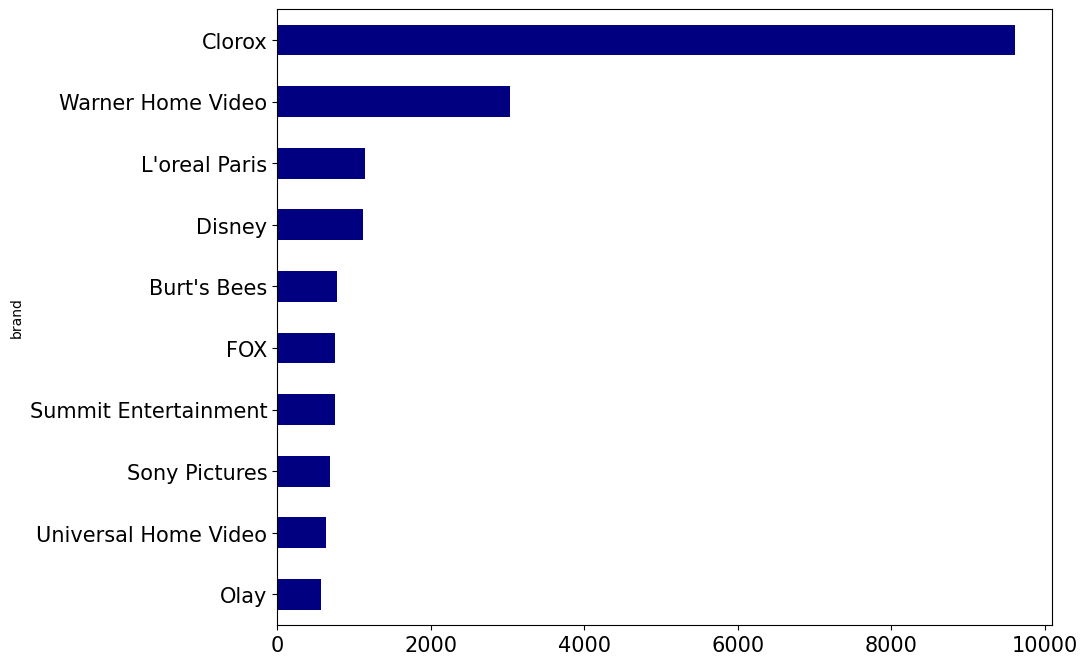

In [12]:
# Getting top 10 products for Positive reviewed products
from matplotlib import cm
result = master_df[(master_df.user_sentiment=="Positive")]
result['brand'].value_counts()[0:10].plot(kind = 'barh', figsize=[10,8], fontsize=15,color='navy').invert_yaxis()

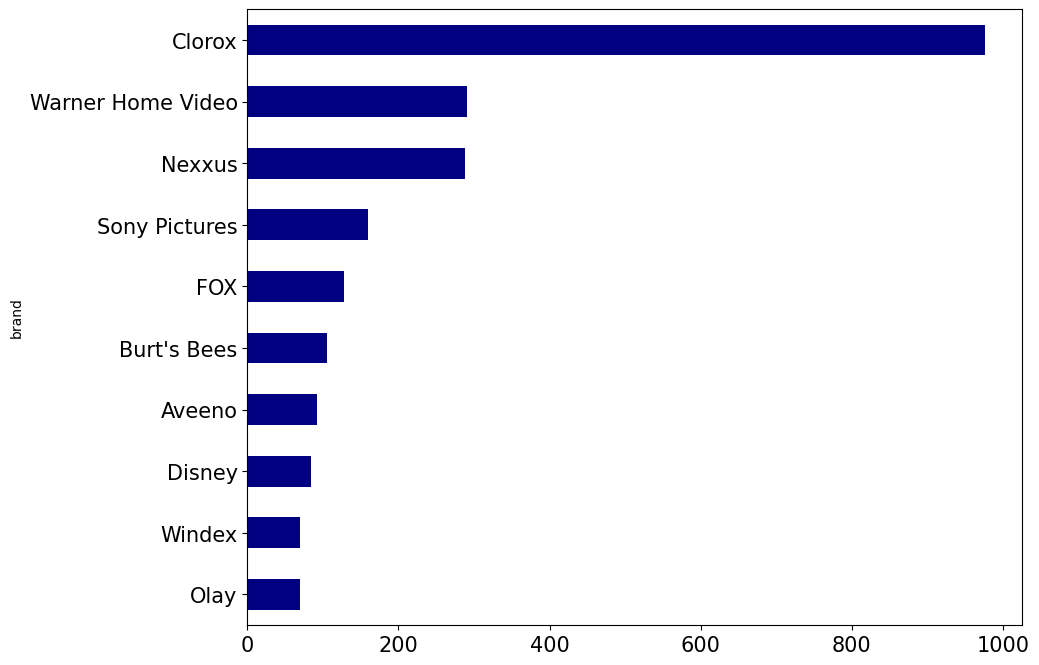

In [13]:
# Getting top 10 products for Negative reviewed products
from matplotlib import cm
result = master_df[(master_df.user_sentiment=="Negative")]
result['brand'].value_counts()[0:10].plot(kind = 'barh', figsize=[10,8], fontsize=15,color='navy').invert_yaxis()

**Observation:** Brands - Clorox & Warner Home Video are the brands which are rating highest as Postive & Negative as well.

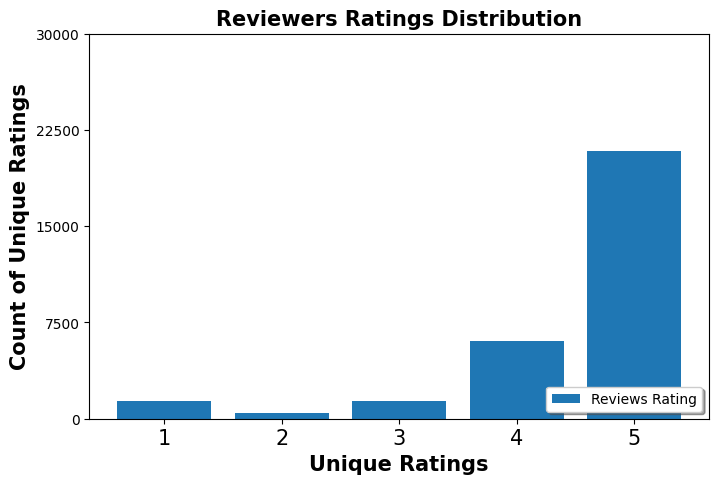

In [14]:
# Number of occurrences for each rating
# Plotting the frequency distribution of ratings

# Setting the size of the figure (width, height) to make the plot more readable.
plt.figure(figsize=[8,5])
x = list(master_df['reviews_rating'].value_counts().index)
y = list(master_df['reviews_rating'].value_counts())

# Creating a bar plot with ratings on the x-axis and their counts on the y-axis.
plt.bar(x, y)

# Customizing the x-tick labels' font size to 15 for better readability.
plt.xticks(size=15)
ticks_y = np.linspace(0, 30000, 5)
plt.yticks(ticks_y, fontsize=10, color='black')

# Adding a title to the plot, with customized font size, weight, color, and alignment (center).
plt.title('Reviewers Ratings Distribution', fontsize=15, weight='bold', color='black', loc='center')

# Labeling the x-axis ('Count') and y-axis ('Ratings')
plt.xlabel('Unique Ratings', fontsize=15, weight='bold', color='black')
plt.ylabel('Count of Unique Ratings', fontsize=15, weight='bold', color='black')

# Adding a legend to the plot, with shadow effect and specifying the location.
plt.legend(['Reviews Rating'], shadow=True, loc=4)

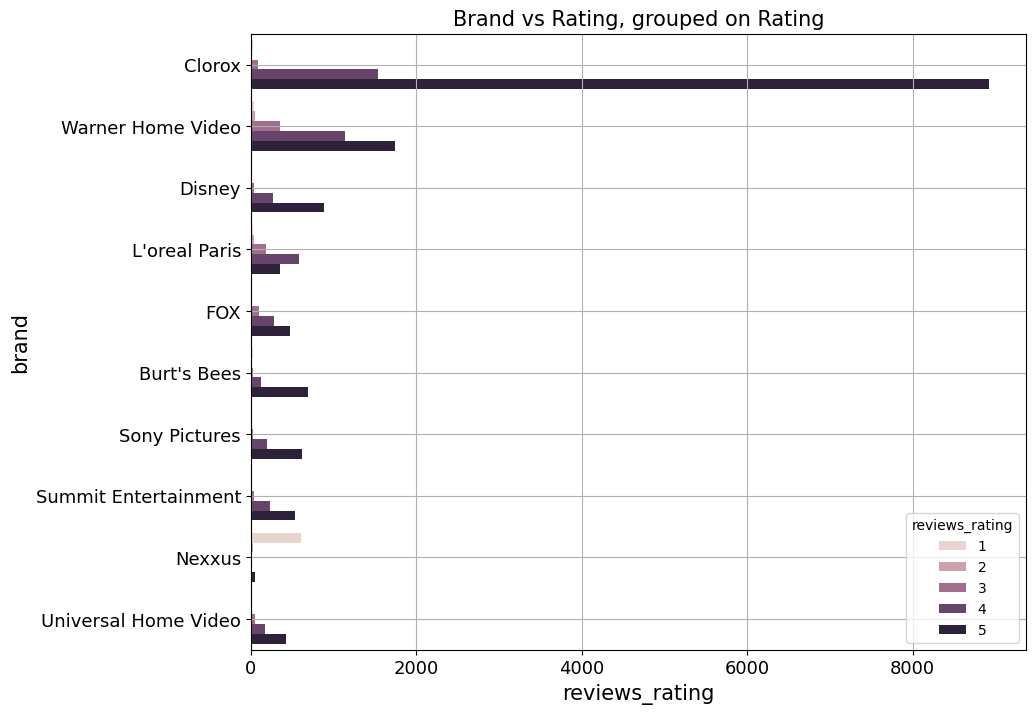

In [15]:
#Now checking Brand vs Rating

plt.figure(figsize=(10,8))
ax = sns.countplot(y=master_df['brand'], hue=master_df['reviews_rating'], order=master_df['brand'].value_counts().iloc[:10].index)
ax.set_xlabel(xlabel="reviews_rating", fontsize=15)
ax.set_ylabel(ylabel='brand', fontsize=15)
ax.axes.set_title('Brand vs Rating, grouped on Rating', fontsize=15)
ax.tick_params(labelsize=13)
plt.grid()
plt.show()


**Observation:** Clorox Brand is the one which has received maximum ratings might be because of which it has received more Positive & Negative reviews.

#### **Step 2 - Text Preprocessing**

In [16]:
# Checking the no of unique values for each column
master_df.nunique()

,0
id,271
brand,214
categories,270
manufacturer,227
name,271
reviews_date,6857
reviews_didPurchase,2
reviews_doRecommend,2
reviews_rating,5
reviews_text,27282


In [17]:
# Checking the different columns in the dataset
master_df.columns

Index(['id', 'brand', 'categories', 'manufacturer', 'name', 'reviews_date',
       'reviews_didPurchase', 'reviews_doRecommend', 'reviews_rating',
       'reviews_text', 'reviews_title', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [18]:
# Extracting only Review comment and user sentiment as dataframe
review_df=master_df[['reviews_text','reviews_rating','user_sentiment']]
data=review_df
data.head()

,reviews_text,reviews_rating,user_sentiment
0,i love this album. it's very good. more to the...,5,Positive
1,Good flavor. This review was collected as part...,5,Positive
2,Good flavor.,5,Positive
3,I read through the reviews on here before look...,1,Negative
4,My husband bought this gel for us. The gel cau...,1,Negative


In [19]:
# Getting the % of null values in each column of review df
round((review_df.isnull().sum()/review_df.isnull().count())*100,2)

,0
reviews_text,0.0
reviews_rating,0.0
user_sentiment,0.0


As we can see there are no/very less null values & hence using these 3 relevant columns to buid model & generate recommendation system

In [20]:
# function to clean the text using re library
def clean_text(text):
  text = text.lower()
  text = re.sub('[0-9]','',text)
  text = re.sub(r'[^a-zA-Z\s]','',text)
  return text

# function to lemmatize the text after cleaning and removing the stopwords
def lemmatize_text(text):
    text= clean_text(text)
    sent = nlp(text)
    sentence = [token.lemma_ for token in sent if token not in set(stopwords.words('english'))]
    return " ".join(sentence)

In [21]:
#Checking the review for which user sentiment is null.
review_df[review_df.user_sentiment.isnull()]

,reviews_text,reviews_rating,user_sentiment
28354,my kids absolutely loved this film so much tha...,5,NaN


In [22]:
# Mapping the reviews ratings - Negative & Postive to '0' and '1' respectively.
# For NaN, looks like reviews_rating is 5 & review text also looks Postive, hence filling the Nan with 1 (basically making it as Positive)
review_df['encoded_user_sentiment'] = review_df['user_sentiment'].map({'Negative':0,'Positive':1}).fillna(1)
review_df['lemmatized_user_sentiment'] = review_df['reviews_text'].map(lambda text: lemmatize_text(text))
review_df.head()

/tmp/ipython-input-1275709784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['encoded_user_sentiment'] = review_df['user_sentiment'].map({'Negative':0,'Positive':1}).fillna(1)
/tmp/ipython-input-1275709784.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df['lemmatized_user_sentiment'] = review_df['reviews_text'].map(lambda text: lemmatize_text(text))


,reviews_text,reviews_rating,user_sentiment,encoded_user_sentiment,lemmatized_user_sentiment
0,i love this album. it's very good. more to the...,5,Positive,1.0,I love this album its very good more to the hi...
1,Good flavor. This review was collected as part...,5,Positive,1.0,good flavor this review be collect as part of ...
2,Good flavor.,5,Positive,1.0,good flavor
3,I read through the reviews on here before look...,1,Negative,0.0,I read through the review on here before look ...
4,My husband bought this gel for us. The gel cau...,1,Negative,0.0,my husband buy this gel for we the gel cause i...


In [23]:
review_df.encoded_user_sentiment.value_counts()

,count
encoded_user_sentiment,
1.0,26633
0.0,3367


In [24]:
### Total reviews
# Calculate the total number of reviews by getting the length of the 'reviews_text' column.
total = len(master_df['reviews_text'])
print("Number of reviews: ", total)

### How many unique reviewers?
# Get the number of unique reviewers by counting the unique values in the 'reviews_username' column.
print("Number of unique reviewers: ", len(master_df['reviews_username'].unique()))

# Calculate the proportion of unique reviewers to the total number of reviews.
reviewer_prop = float(len(master_df['reviews_username'].unique()) / total)
print("Proportion of unique reviewers: ", round(reviewer_prop, 3))

### Average star score
# Calculate the average rating score by taking the mean of the 'reviews_rating' column.
print("Average rating score: ", round(master_df['reviews_rating'].mean(), 3))

Number of reviews:  30000
Number of unique reviewers:  24915
Proportion of unique reviewers:  0.831
Average rating score:  4.483


#### **Step 3 - Feature Extraction**

In [25]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(review_df['lemmatized_user_sentiment'],review_df['encoded_user_sentiment'],train_size=0.70,random_state=45)
print('x_train shape = ',x_train.shape)
print('x_test shape = ',x_test.shape)
print('y_train shape = ',y_train.shape)
print('y_test shape = ',y_test.shape)

x_train shape =  (21000,)
x_test shape =  (9000,)
y_train shape =  (21000,)
y_test shape =  (9000,)


#### TF-IDF Vectorizer

In [26]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from collections import Counter
from imblearn.over_sampling import SMOTE

count_vect = CountVectorizer()
x_count = count_vect.fit_transform(x_train)

tfidf_transformer = TfidfTransformer()
x_train_transformed = tfidf_transformer.fit_transform(x_count)
x_train_transformed.shape

(21000, 14129)

In [30]:
import pickle
# Saving the Count Vectorizer & tfidf transformer pickle files
pickle.dump(count_vect, open('count_vectorizer.pkl', 'wb'))

pickle.dump(tfidf_transformer, open('tfidf_transformer.pkl', 'wb'))

In [32]:
count = Counter(y_train)
print('Before sampling :',count)

sampler = SMOTE()

x_train_sm,y_train_sm = sampler.fit_resample(x_train_transformed,y_train)

count = Counter(y_train_sm)
print('After sampling :',count)

Before sampling : Counter({1.0: 18675, 0.0: 2325})
After sampling : Counter({1.0: 18675, 0.0: 18675})


#### **Step 4 - Model Building**

In [33]:
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,f1_score,precision_score,accuracy_score
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB

In [34]:
# Function for Metrics for calculating Accuracy, ROC Score, Confusion Matrix, F1-Score, Sensitivity, Specificity
performance=[]
def model_metrics(y,y_pred,model_name,metrics):
  Accuracy = accuracy_score(y,y_pred)
  roc = roc_auc_score(y,y_pred)
  confusion = confusion_matrix(y,y_pred)
  precision = precision_score(y,y_pred)
  f1 = f1_score(y,y_pred)
  TP = confusion[1,1]  # true positive
  TN = confusion[0,0]  # true negatives
  FP = confusion[0,1]  # false positives
  FN = confusion[1,0]  # false negatives
  sensitivity= TP / float(TP+FN)
  specificity = TN / float(TN+FP)

  print("*"*50)
  print('Confusion Matrix =')
  print(confusion)
  print("sensitivity of the %s = %f" % (model_name,round(sensitivity,2)))
  print("specificity of the %s = %f" % (model_name,round(specificity,2)))
  print("Accuracy Score of %s = %f" % (model_name,Accuracy))
  print('ROC AUC score of %s = %f' % (model_name,roc))
  print("Report=",)
  print(classification_report(y,y_pred))
  print("*"*50)
  metrics.append(dict({'Model_name':model_name,
                       'Accuracy':Accuracy,
                       'Roc_auc_score':roc,
                       'Precision':precision,
                       'F1_score':f1}))
  return metrics

**4.1. Logistic Regression**

In [35]:
lr = LogisticRegression()
lr.fit(x_train_sm,y_train_sm)

LogisticRegression()

In [36]:
x_train_sm

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1140698 stored elements and shape (37350, 14129)>

In [37]:
y_pred_lr = lr.predict(x_train_sm)
y_pred_lr

array([1., 0., 1., ..., 0., 0., 0.])

In [38]:
y_pred_lr = lr.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_lr,'Logistic Regression',performance)
performance

**************************************************
Confusion Matrix =
[[18280   395]
 [ 1472 17203]]
sensitivity of the Logistic Regression = 0.920000
specificity of the Logistic Regression = 0.980000
Accuracy Score of Logistic Regression = 0.950013
ROC AUC score of Logistic Regression = 0.950013
Report=
              precision    recall  f1-score   support

         0.0       0.93      0.98      0.95     18675
         1.0       0.98      0.92      0.95     18675

    accuracy                           0.95     37350
   macro avg       0.95      0.95      0.95     37350
weighted avg       0.95      0.95      0.95     37350

**************************************************


[{'Model_name': 'Logistic Regression',
  'Accuracy': 0.9500133868808568,
  'Roc_auc_score': np.float64(0.9500133868808568),
  'Precision': 0.9775542675304012,
  'F1_score': 0.948529209053566}]

**4.2. RandomForest Classifier**

In [39]:
rf = RandomForestClassifier()
rf.fit(x_train_sm,y_train_sm)

RandomForestClassifier()

In [40]:
y_pred_rf = rf.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_rf,'RandomForestClassifier',performance)
performance

**************************************************
Confusion Matrix =
[[18675     0]
 [    0 18675]]
sensitivity of the RandomForestClassifier = 1.000000
specificity of the RandomForestClassifier = 1.000000
Accuracy Score of RandomForestClassifier = 1.000000
ROC AUC score of RandomForestClassifier = 1.000000
Report=
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18675
         1.0       1.00      1.00      1.00     18675

    accuracy                           1.00     37350
   macro avg       1.00      1.00      1.00     37350
weighted avg       1.00      1.00      1.00     37350

**************************************************


[{'Model_name': 'Logistic Regression',
  'Accuracy': 0.9500133868808568,
  'Roc_auc_score': np.float64(0.9500133868808568),
  'Precision': 0.9775542675304012,
  'F1_score': 0.948529209053566},
 {'Model_name': 'RandomForestClassifier',
  'Accuracy': 1.0,
  'Roc_auc_score': np.float64(1.0),
  'Precision': 1.0,
  'F1_score': 1.0}]

**4.3. GradientBoostClassifier**

In [41]:
xgb = GradientBoostingClassifier()
xgb.fit(x_train_sm,y_train_sm)

GradientBoostingClassifier()

In [42]:
y_pred_xgb = xgb.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_rf,'AdaBoostclassifier',performance)
performance

**************************************************
Confusion Matrix =
[[18675     0]
 [    0 18675]]
sensitivity of the AdaBoostclassifier = 1.000000
specificity of the AdaBoostclassifier = 1.000000
Accuracy Score of AdaBoostclassifier = 1.000000
ROC AUC score of AdaBoostclassifier = 1.000000
Report=
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     18675
         1.0       1.00      1.00      1.00     18675

    accuracy                           1.00     37350
   macro avg       1.00      1.00      1.00     37350
weighted avg       1.00      1.00      1.00     37350

**************************************************


[{'Model_name': 'Logistic Regression',
  'Accuracy': 0.9500133868808568,
  'Roc_auc_score': np.float64(0.9500133868808568),
  'Precision': 0.9775542675304012,
  'F1_score': 0.948529209053566},
 {'Model_name': 'RandomForestClassifier',
  'Accuracy': 1.0,
  'Roc_auc_score': np.float64(1.0),
  'Precision': 1.0,
  'F1_score': 1.0},
 {'Model_name': 'AdaBoostclassifier',
  'Accuracy': 1.0,
  'Roc_auc_score': np.float64(1.0),
  'Precision': 1.0,
  'F1_score': 1.0}]

**4.4. Naive Bayes**

In [43]:
mnb = MultinomialNB()
mnb.fit(x_train_sm,y_train_sm)

MultinomialNB()

In [44]:
y_pred_mnb = mnb.predict(x_train_sm)
performance = model_metrics(y_train_sm,y_pred_mnb,'Naive_Bayes',performance)
performance

**************************************************
Confusion Matrix =
[[17410  1265]
 [ 2122 16553]]
sensitivity of the Naive_Bayes = 0.890000
specificity of the Naive_Bayes = 0.930000
Accuracy Score of Naive_Bayes = 0.909317
ROC AUC score of Naive_Bayes = 0.909317
Report=
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     18675
         1.0       0.93      0.89      0.91     18675

    accuracy                           0.91     37350
   macro avg       0.91      0.91      0.91     37350
weighted avg       0.91      0.91      0.91     37350

**************************************************


[{'Model_name': 'Logistic Regression',
  'Accuracy': 0.9500133868808568,
  'Roc_auc_score': np.float64(0.9500133868808568),
  'Precision': 0.9775542675304012,
  'F1_score': 0.948529209053566},
 {'Model_name': 'RandomForestClassifier',
  'Accuracy': 1.0,
  'Roc_auc_score': np.float64(1.0),
  'Precision': 1.0,
  'F1_score': 1.0},
 {'Model_name': 'AdaBoostclassifier',
  'Accuracy': 1.0,
  'Roc_auc_score': np.float64(1.0),
  'Precision': 1.0,
  'F1_score': 1.0},
 {'Model_name': 'Naive_Bayes',
  'Accuracy': 0.9093172690763052,
  'Roc_auc_score': np.float64(0.9093172690763052),
  'Precision': 0.9290043775956898,
  'F1_score': 0.9071876798290083}]

In [45]:
metrics_df=pd.DataFrame(performance)
metrics_df

,Model_name,Accuracy,Roc_auc_score,Precision,F1_score
0,Logistic Regression,0.950013,0.950013,0.977554,0.948529
1,RandomForestClassifier,1.000000,1.000000,1.000000,1.000000
2,AdaBoostclassifier,1.000000,1.000000,1.000000,1.000000
3,Naive_Bayes,0.909317,0.909317,0.929004,0.907188


In [48]:
# Based on the metrics, looks like Logistic Regression performs well & hence saving the Logistic Regression model

pickle.dump(lr, open('logistic_regression.pkl', 'wb'))

#### **Step 5 - Recommendation Systems**


**5.1. User and User Based Recommendation System**

In [49]:
master_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [50]:
recommend_train,recommend_test = train_test_split(master_df,train_size=0.70,random_state=45)
print('Recommendation train shape = ',recommend_train.shape)
print('Recommendation test shape = ',recommend_test.shape)

Recommendation train shape =  (21000, 13)
Recommendation test shape =  (9000, 13)


In [51]:
train_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=recommend_train).fillna(1)
train_pivot.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [52]:
# here we are going use the adjusted cosine similarity

def cosine_similarity(df):

  # using the adjusted cosine similarity
  mean_df = np.nanmean(df,axis=1)
  substracted_df = (df.T - mean_df).T # Normalized dataset

  # using the pairwise_distance for cosine similarity
  user_correlation = 1- pairwise_distances (substracted_df.fillna(0),metric='cosine')
  user_correlation[np.isnan(user_correlation)] = 0

  return user_correlation,substracted_df

In [53]:
user_corr_matrix,normalized_df = cosine_similarity(train_pivot)
user_corr_matrix

array([[ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       [-0.00395257,  1.        ,  1.        , ..., -0.00395257,
        -0.00395257, -0.00395257],
       ...,
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [-0.00395257, -0.00395257, -0.00395257, ...,  1.        ,
         1.        , -0.00395257],
       [ 1.        , -0.00395257, -0.00395257, ..., -0.00395257,
        -0.00395257,  1.        ]])

In [54]:
user_corr_matrix.shape

(18205, 18205)

In [55]:
user_corr_matrix[user_corr_matrix < 0] = 0
user_corr_matrix.shape

(18205, 18205)

In [56]:
train_pivot_na = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=recommend_train)
train_pivot_na.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
06stidriver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
user_pred_ratings = np.dot(user_corr_matrix,train_pivot_na.fillna(0))
user_pred_ratings

array([[ 0.        ,  0.68558199,  0.        , ...,  7.58053964,
         2.87531862,  0.        ],
       [ 0.        , 24.07051811,  0.        , ..., 16.96119551,
         0.        ,  2.4911209 ],
       [ 0.        , 24.07051811,  0.        , ..., 16.96119551,
         0.        ,  2.4911209 ],
       ...,
       [ 0.        ,  5.62372034,  0.        , ...,  8.73443108,
         3.52853977,  0.        ],
       [ 0.        ,  5.62372034,  0.        , ...,  8.73443108,
         3.52853977,  0.        ],
       [ 0.        ,  0.68558199,  0.        , ...,  7.58053964,
         2.87531862,  0.        ]])

In [58]:
user_pred_ratings.shape

(18205, 254)

In [59]:
user_final_rating = np.multiply(user_pred_ratings,train_pivot)
user_final_rating.head()

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.685582,0.0,0.0,2.875319,0.0,0.0,0.0,0.0,4.883706,...,0.00000,0.0,0.000000,0.0,1.397036,0.0,0.0,7.580540,2.875319,0.000000
02dakota,0.0,24.070518,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,16.501214,...,0.00000,0.0,2.491121,0.0,2.593420,0.0,0.0,16.961196,0.000000,2.491121
02deuce,0.0,24.070518,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,16.501214,...,0.00000,0.0,2.491121,0.0,2.593420,0.0,0.0,16.961196,0.000000,2.491121
0325home,0.0,5.623720,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5.056041,...,11.32214,0.0,0.000000,0.0,0.000000,0.0,0.0,8.734431,3.528540,0.000000
06stidriver,0.0,5.623720,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5.056041,...,11.32214,0.0,0.000000,0.0,0.000000,0.0,0.0,8.734431,3.528540,0.000000


Evaluation of User and User Based Recommendation System

In [60]:
common = recommend_test[recommend_test.reviews_username.isin(recommend_train.reviews_username)]
common.shape

(2006, 13)

In [61]:
corr_df = pd.DataFrame(user_corr_matrix)
corr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [62]:
corr_df['user_name'] = normalized_df.index
corr_df.set_index('user_name',inplace=True)
corr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18195,18196,18197,18198,18199,18200,18201,18202,18203,18204
user_name,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
02dakota,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
06stidriver,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0


In [63]:
list_name = common.reviews_username.tolist()

In [64]:
corr_df.columns = normalized_df.index.tolist()
corr_df.columns

Index(['00sab00', '02dakota', '02deuce', '0325home', '06stidriver', '1.11E+24',
       '1085', '10ten', '11111111aaaaaaaaaaaaaaaaa', '11677j',
       ...
       'zowie', 'zozo0o', 'zsazsa', 'zt313', 'zubb', 'zuttle', 'zwithanx',
       'zxcsdfd', 'zyiah4', 'zzdiane'],
      dtype='object', length=18205)

In [65]:
corr_df1 = corr_df[corr_df.index.isin(list_name)]
corr_df1.shape

(1687, 18205)

In [66]:
corr_df2 = corr_df1.T[corr_df1.T.index.isin(list_name)]
corr_df3 = corr_df2.T
corr_df3.head()

,1234,123charlie,143st,1943,4cloroxl,50cal,7inthenest,aac06002,aaron,abby,...,yeya,ygtz,yohnie1,yshan,yucky111,yummy,yvonne,zburt5,zebras,zippy
user_name,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.684558,0.0,0.223114,0.0,0.511718,0.0,0.0,0.837534,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.278697
123charlie,0.684558,1.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.656818,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
143st,0.000000,0.000000,1.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1943,0.223114,0.000000,0.0,1.000000,0.0,0.444381,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.242522
4cloroxl,0.000000,0.000000,0.0,0.000000,1.0,0.000000,1.0,0.0,0.000000,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000


In [67]:
common_user_tb = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)
common_user_tb.head()

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
corr_df3[corr_df3<0] = 0
common_user_rating =  np.dot(corr_df3,common_user_tb.fillna(0))
common_user_rating

array([[7.4987797 , 1.20864234, 0.        , ..., 7.64092148, 0.92858292,
        0.        ],
       [1.74826633, 0.        , 0.        , ..., 3.36140237, 0.        ,
        0.        ],
       [5.67106405, 5.        , 0.        , ..., 5.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [2.87531862, 0.        , 0.        , ..., 6.10152667, 0.        ,
        0.        ],
       [6.79815093, 1.31072544, 1.07870809, ..., 5.89883029, 1.01174853,
        0.        ]])

In [69]:
dummy_test = common.copy()
dummy_test['reviews_rating'] =dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=dummy_test).fillna(0)
dummy_test.head()

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
common_user_pred_ratings =  np.multiply(common_user_rating,dummy_test)
common_user_pred_ratings.head()

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,68.109936,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_pred_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))

y = (scaler.transform(X))
print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


(1687, 120)

In [72]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
total_non_nan

1787

In [73]:
common_pivot = pd.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating',data=common)
common_pivot.head()

name,100:Complete First Season (blu-Ray),Alex Cross (dvdvideo),"Aussie Aussome Volume Shampoo, 13.5 Oz","Australian Gold Exotic Blend Lotion, SPF 4","Aveeno Baby Continuous Protection Lotion Sunscreen with Broad Spectrum SPF 55, 4oz","Avery174 Ready Index Contemporary Table Of Contents Divider, 1-8, Multi, Letter",Axe Dry Anti-Perspirant Deodorant Invisible Solid Phoenix,"BRIDGESTONE 130/70ZR18M/C(63W)FRONT EXEDRA G851, CRUISER RADL","Banana Boat Sunless Summer Color Self Tanning Lotion, Light To Medium",Barielle Nail Rebuilding Protein,...,Vaseline Intensive Care Healthy Hands Stronger Nails,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1943,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4cloroxl,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
rmse = (sum(sum((common_pivot -  y )**2))/total_non_nan)**0.5
print(rmse)

1.8755890184650454


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


**6.2. Item and Item Based Recommendation System**

In [75]:
train_pivot_naT = train_pivot_na.T
train_pivot_naT.head()

reviews_username,00sab00,02dakota,02deuce,0325home,06stidriver,1.11E+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,11677j,...,zowie,zozo0o,zsazsa,zt313,zubb,zuttle,zwithanx,zxcsdfd,zyiah4,zzdiane
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100:Complete First Season (blu-Ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x Ultra Era with Oxi Booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
item_corr_matrix, normalized_item_df = cosine_similarity(train_pivot_naT)
item_corr_matrix.shape

(254, 254)

In [77]:
item_pred_rating = np.dot((train_pivot_naT.fillna(0)).T,item_corr_matrix)
item_pred_rating[item_pred_rating<0] = 0
item_pred_rating

array([[0.        , 0.03208201, 0.        , ..., 0.        , 0.00559512,
        0.        ],
       [0.        , 0.01466226, 0.        , ..., 0.00339133, 0.        ,
        0.00215432],
       [0.        , 0.01172981, 0.        , ..., 0.00271307, 0.        ,
        0.00172346],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.00178442,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00178442,
        0.        ],
       [0.        , 0.04032657, 0.        , ..., 0.        , 0.0093252 ,
        0.        ]])

In [78]:
#final rating for items
item_final_rating = np.multiply(item_pred_rating,train_pivot)
item_final_rating

name,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.032082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031146,...,0.121506,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.005595,0.000000
02dakota,0.0,0.014662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.015873,...,0.000000,0.0,0.019220,0.0,0.016958,0.0,0.0,0.003391,0.000000,0.002154
02deuce,0.0,0.011730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012698,...,0.000000,0.0,0.015376,0.0,0.013567,0.0,0.0,0.002713,0.000000,0.001723
0325home,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001784,0.000000
06stidriver,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001784,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zuttle,0.0,0.007767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000
zwithanx,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001784,0.000000
zxcsdfd,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001784,0.000000


Evaluation for item and item

In [79]:
common_item = recommend_test[recommend_test.name.isin(recommend_train.name)]
common_item.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
19154,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-12-30T00:00:00.000Z,False,True,5,"Very powerful, great at removing stains, and s...",Clorox Rocks,briley,Positive
22871,AVpfov9TLJeJML43A7B0,Bisquick,"Food & Beverage,Baking & Cooking Essentials,Ba...","GENERAL MILLS SALES, INC.",Bisquick Original Pancake And Baking Mix - 40oz,2012-07-25T00:00:00.000Z,False,True,5,you can do sooooo much with this product..bisc...,Alot of a good thing!!!,foxfire61,Positive
11830,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox,Clorox Disinfecting Wipes Value Pack Scented 1...,2014-12-05T00:00:00.000Z,False,True,5,I love the lemon fresh smell it leaves. I know...,Keep Cancer Home Germ Free,margies,Positive
707,AV1YGDqsGV-KLJ3adc-O,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex,Windex Original Glass Cleaner Refill 67.6oz (2...,2015-08-18T00:00:00.000Z,False,False,1,Windex used to be the best but whatever they h...,no longer a good glass cleaner,mel,Negative
20513,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",AmazonUs/CLOO7,Clorox Disinfecting Bathroom Cleaner,2014-04-07T12:05:20.000Z,NaN,NaN,5,I have two sons and they make a mess in their ...,Great In Showers,jillybeansoccermom,Negative


In [80]:
common_item_pivot = common_item.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T
common_item_pivot.shape

(206, 8379)

In [81]:
item_corr_df = pd.DataFrame(item_corr_matrix)
item_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005034,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [82]:
item_corr_df['name'] = normalized_item_df.index
item_corr_df.set_index('name',inplace=True)
item_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,244,245,246,247,248,249,250,251,252,253
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005034,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [83]:
list_items = common_item.name.tolist()
item_corr_df.columns = normalized_item_df.index.tolist()
item_corr_df

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,-0.005034,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.000000,0.0,0.0
Weleda Everon Lip Balm,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.000000,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,-0.005034,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003554,...,0.0,0.0,0.0,0.0,-0.017058,0.0,0.0,1.000000,0.0,0.0


In [84]:
len(list_items)

8983

In [85]:
item_corr_df1 = item_corr_df[item_corr_df.index.isin(list_items)]
item_corr_df1.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz","42 Dual Drop Leaf Table with 2 Madrid Chairs""",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,5302050 15/16 FCT/HOSE ADAPTOR,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),...,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,Walkers Stem Ginger Shortbread,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005034,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [86]:
item_corr_df2 = item_corr_df1.T[item_corr_df1.T.index.isin(list_items)]
item_corr_df3 = item_corr_df2.T
item_corr_df3.head()

,0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,100:Complete First Season (blu-Ray),2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,"2x Ultra Era with Oxi Booster, 50fl oz",4C Grated Parmesan Cheese 100% Natural 8oz Shaker,Africa's Best No-Lye Dual Conditioning Relaxer System Super,Alberto VO5 Salon Series Smooth Plus Sleek Shampoo,Alex Cross (dvdvideo),"All,bran Complete Wheat Flakes, 18 Oz.",Ambi Complexion Cleansing Bar,...,Vaseline Intensive Care Lip Therapy Cocoa Butter,"Vicks Vaporub, Regular, 3.53oz",Voortman Sugar Free Fudge Chocolate Chip Cookies,Wagan Smartac 80watt Inverter With Usb,"Way Basics 3-Shelf Eco Narrow Bookcase Storage Shelf, Espresso - Formaldehyde Free - Lifetime Guarantee","WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",Weleda Everon Lip Balm,Windex Original Glass Cleaner Refill 67.6oz (2 Liter),Yes To Carrots Nourishing Body Wash,Yes To Grapefruit Rejuvenating Body Wash
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
100:Complete First Season (blu-Ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.005034,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [87]:
item_corr_df3[item_corr_df3<0] = 0
common_item_pred_ratings = np.dot(item_corr_df3,common_item_pivot.fillna(0))
common_item_pred_ratings.shape

(206, 8379)

In [88]:
test_items = common_item.copy()

In [89]:
test_item_tb = test_items.pivot_table(index='reviews_username',
                            columns='name',
                            values='reviews_rating').T.fillna(0)
final_item_ratings = np.multiply(common_item_pred_ratings,test_item_tb)
final_item_ratings

reviews_username,00dog3,01impala,08dallas,09mommy11,1143mom,1234,123charlie,123numbers,12cass12,132457,...,zombiedad80,zombiegirl22,zombiekiller,zoney86,zookeeper,zpalma,zsarah,zulaa118,zxjki,zzz1127
name,,,,,,,,,,,,,,,,,,,,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:Complete First Season (blu-Ray),0.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x Ultra Era with Oxi Booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4C Grated Parmesan Cheese 100% Natural 8oz Shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"WeatherTech 40647 14-15 Outlander Cargo Liners Behind 2nd Row, Black",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Weleda Everon Lip Balm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Windex Original Glass Cleaner Refill 67.6oz (2 Liter),0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
X  = final_item_ratings.copy()
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))

y = (scaler.transform(X))
print(y)
y.shape

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan  1. ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:776: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmin(X, axis=axis))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/_array_api.py:793: RuntimeWarning: All-NaN slice encountered
  return xp.asarray(numpy.nanmax(X, axis=axis))


(206, 8379)

In [91]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [92]:
rmse = (sum(sum((common_item_pivot -  y )**2))/total_non_nan)**0.5
print(rmse)

3.5578941070687096


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


User-user recommendation is having less RMSE than Item-Item Recommendation system. Hence using them for recommending products.

In [94]:
# Since User-user recommendation system looks good, saving user

pickle.dump(user_final_rating, open('user_final_rating.pkl', 'wb'))

#### **Step 6 - Top 20 Products Recommendation Systems**

Since the user-user recommendation system has less RMSE we can go ahead with User recommendation system.
Enter the user name:
Recommended top 20 products for the user:

In [95]:
print('Enter the user name:')
user_name = input()

Enter the user name:
motosa


In [96]:
print(f"Recommended top 20 products of the user - {user_name}")
user_final_rating.loc[user_name].sort_values(ascending=False)[:20]

Recommended top 20 products of the user - motosa


,motosa
name,
Red (special Edition) (dvdvideo),10606.107978
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd,64.805135
Mike Dave Need Wedding Dates (dvd + Digital),30.027424
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),21.652750
The Resident Evil Collection 5 Discs (blu-Ray),17.415399
My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital),15.089315
Tostitos Bite Size Tortilla Chips,10.232223
Chester's Cheese Flavored Puffcorn Snacks,8.925690
Alex Cross (dvdvideo),6.739319
